In [128]:
import io
import os
import sys
import csv
import time
import einops
import pickle
import random
import subprocess
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp import optimization
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
from PIL import Image

## Hyper parameters

In [129]:
LEARNING_RATE = 1e-1 # 1e-2, 1e-3, 1e-4, 3e-5, 1e-5, 1e-6
EPOCHS = 20
G_BATCH_SIZE = 16
OPTIMIZER_TYPE = 'adamw' # Common optimizers include Adam, SGD, RMSprop,

In [130]:
Accuracy = 0
Loss = 0
Validation_accuracy = 0
Validation_loss = 0

In [131]:
# Verify TensorFlow can detect the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if len(gpus) > 0:
    print(f"Using GPU: {gpus[0].device_type} {gpus[0].name}")
else:
    print("No GPU detected. Running on CPU.")

Num GPUs Available: 1
Using GPU: GPU /physical_device:GPU:0


In [132]:
def append_dict_to_csv(row_dict, csv_file_name):
    # Open the file in append mode (or create it if it doesn't exist)
    with open(csv_file_name, mode='a', newline='', encoding='utf-8') as csv_file:
        # Create a writer object
        writer = csv.DictWriter(csv_file, fieldnames=row_dict.keys())
        
        # Write the data row
        writer.writerow(row_dict)


def insert_image_in_pdf(image_path, pdf_canvas, x, y, width=224, height=224):
    """Insert an image into the PDF canvas."""
    img = Image.open(image_path)
    
    # Resize the image by 50%
    new_width = int(width * 0.5)
    new_height = int(height * 0.5)
    img = img.resize((new_width, new_height))
    
    # Convert PIL Image to a data stream compatible with reportlab
    img_buffer = io.BytesIO()
    img.save(img_buffer, format='PNG')
    img_buffer.seek(0)
    
    pdf_canvas.drawImage(ImageReader(img_buffer), x, y, new_width, new_height)


def generate_pdf_from_csv(csv_file_name, output_file_name):
    c = canvas.Canvas(output_file_name, pagesize=letter)
    width, height = letter
    
    # Define table headers
    headers = ["S/N", "Image", "Caption", "Match", "Un-match"]
    
    # Starting positions
    x = 50
    y = height - 50  # Start from the top of the page
    row_height = 150  # Adjusted for image height
    col_widths = [30, 180, 180, 80, 80]  # Adjust the column widths as needed
    
    # Draw Table Header
    for idx, header in enumerate(headers):
        c.drawString(x + sum(col_widths[:idx]), y, header)
    
    y -= row_height
    
    # Read data from CSV and fill in the table rows
    with open(csv_file_name, mode='r', newline='', encoding='utf-8') as csv_file:
        reader = csv.DictReader(csv_file)
        for sn, row in enumerate(reader, start=1):
            c.drawString(x, y + (row_height - 12) / 2, str(sn))
            
            # Insert image
            insert_image_in_pdf(row["Image"], c, x + col_widths[0], y)
            
            # Text columns
            # Remove the "b'" characters from the start of the caption
            caption = row["Caption"].lstrip("b'")

            # Split caption into multiple lines if it's too long
            caption_lines = [caption[i:i+25] for i in range(0, len(caption), 25)]
            for idx, line in enumerate(caption_lines):
                c.drawString(x + sum(col_widths[:2]), y + (row_height - 12) / 2 - (idx * 12 * 0.8), line)
            
            c.drawString(x + sum(col_widths[:3]), y + (row_height - 12) / 2, row["Match"])
            c.drawString(x + sum(col_widths[:4]), y + (row_height - 12) / 2, row["Un-match"])
            
            y -= row_height
            if y < 100:  # Check for page end
                c.showPage()  # Start a new page
                y = height - 50  # Reset y position
                # Re-draw Table Header on new page
                for idx, header in enumerate(headers):
                    c.drawString(x + sum(col_widths[:idx]), y, header)
                y -= row_height
    
    c.save()
    subprocess.Popen(['xdg-open', output_file_name])
    
    
def plot_training_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [133]:
# Class for loading image and text data

class ITM_DataLoader():
    BATCH_SIZE = G_BATCH_SIZE
    IMAGE_SIZE = (224, 224)
    IMAGE_SHAPE = (224, 224, 3)
    SENTENCE_EMBEDDING_SHAPE = (384)
    AUTOTUNE = tf.data.AUTOTUNE
    IMAGES_PATH = "data/images"
    IMAGES_PATH = "/home/rinzler/Github/Image-Text-Matching/data/images"
    train_data_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.TrainImages.txt"
    dev_data_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.DevImages.txt"
    test_data_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.TestImages.txt"
    sentence_embeddings_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.cmp9137.sentence_transformers.pkl"
    sentence_embeddings = {}
    train_ds = None
    val_ds = None
    test_ds = None

    def __init__(self):
        self.sentence_embeddings = self.load_sentence_embeddings()
        self.train_ds = self.load_classifier_data(self.train_data_file)
        self.val_ds = self.load_classifier_data(self.dev_data_file)
        self.test_ds = self.load_classifier_data(self.test_data_file)
        print("done loading data...")

    # Sentence embeddings are dense vectors representing text data, one vector per sentence. 
    # Sentences with similar vectors would mean sentences with equivalent meanning.  
	# They are useful here to provide text-based features of questions in the data.
    # Note: sentence embeddings don't include label info, they are solely based on captions.
    def load_sentence_embeddings(self):
        sentence_embeddings = {}
        print("READING sentence embeddings...")
        with open(self.sentence_embeddings_file, 'rb') as f:
            data = pickle.load(f)
            for sentence, dense_vector in data.items():
                sentence_embeddings[sentence] = dense_vector
                #print("*sentence=",sentence)
        print("Done reading sentence_embeddings!")
        return sentence_embeddings

    # In contrast to text-data based on pre-trained features, image data does not use
    # any form of pre-training in this program. Instead, it makes use of raw pixels.
    # Notes that input features to the classifier are only pixels and sentence embeddings.
    def process_input(self, img_path, dense_vector, text, label):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255
        features = {}
        features["image_input"] = img
        features["text_embedding"] = dense_vector
        features["caption"] = text
        features["file_name"] = img_path
        return features, label

    # This method loads the multimodal data, which comes from the following sources:
    # (1) image files in IMAGES_PATH, and (2) files with pattern flickr8k.*Images.txt
    # The data is stored in a tensorflow data structure to make it easy to use by
    # the tensorflow model during training, validation and test. This method was 
    # carefully prepared to load the data rapidly, i.e., by loading already created
    # sentence embeddings (text features) rather than creating them at runtime.
    def load_classifier_data(self, data_files):
        print("LOADING data from "+str(data_files))
        print("=========================================")
        image_data = []
        text_data = []
        embeddings_data = []
        label_data = []
		
        # get image, text, label of image_files
        with open(data_files) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip("\n")
                img_name, text, raw_label = line.split("	")
                img_name = os.path.join(self.IMAGES_PATH, img_name.strip())

                # get binary labels from match/no-match answers
                label = [1, 0] if raw_label == "match" else [0, 1]
                #print("I=%s T=%s _L=%s L=%s" % (img_name, text, raw_label, label)) 

				# get sentence embeddings (of textual captions)
                text_sentence_embedding = self.sentence_embeddings[text]
                text_sentence_embedding = tf.constant(text_sentence_embedding)

                image_data.append(img_name)
                embeddings_data.append(text_sentence_embedding)
                text_data.append(text)
                label_data.append(label)

        print("|image_data|="+str(len(image_data)))
        print("|text_data|="+str(len(text_data)))
        print("|label_data|="+str(len(label_data)))
		
        # prepare a tensorflow dataset using the lists generated above
        dataset = tf.data.Dataset.from_tensor_slices((image_data, embeddings_data, text_data, label_data))
        dataset = dataset.shuffle(self.BATCH_SIZE * 8)
        dataset = dataset.map(self.process_input, num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.BATCH_SIZE).prefetch(self.AUTOTUNE)
        self.print_data_samples(dataset)
        return dataset

    def print_data_samples(self, dataset):
        print("PRINTING data samples...")
        print("-----------------------------------------")
        for features_batch, label_batch in dataset.take(1):
            for i in range(1):
                print(f'Image pixels: {features_batch["image_input"]}')
                print(f'Sentence embeddings: {features_batch["text_embedding"]}')
                print(f'Caption: {features_batch["caption"].numpy()}')
                label = label_batch.numpy()[i]
                print(f'Label : {label}')
        print("-----------------------------------------")

In [134]:
# Main class for the Image-Text Matching (ITM) task

class ITM_Classifier(ITM_DataLoader):
    epochs = EPOCHS
    learning_rate = Learning_Rate
    class_names = {'match', 'no-match'}
    num_classes = len(class_names)
    classifier_model = None
    history = None
    classifier_model_name = 'ITM_Classifier-flickr'

    def __init__(self):
        super().__init__()
        self.build_classifier_model()
        self.train_classifier_model()
        self.test_classifier_model()

    # return learnt feature representations of input data (images)
    def create_vision_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        img_input = layers.Input(shape=self.IMAGE_SHAPE, name="image_input")
        cnn_layer = layers.Conv2D(16, 3, padding='same', activation='relu')(img_input)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Conv2D(32, 3, padding='same', activation='relu')(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Conv2D(64, 3, padding='same', activation='relu')(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Dropout(dropout_rate)(cnn_layer)
        cnn_layer = layers.Flatten()(cnn_layer)
        outputs = self.project_embeddings(cnn_layer, num_projection_layers, projection_dims, dropout_rate)
        return img_input, outputs

    # return learnt feature representations based on dense layers, dropout, and layer normalisation
    def project_embeddings(self, embeddings, num_projection_layers, projection_dims, dropout_rate):
        projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.gelu(projected_embeddings)
            x = layers.Dense(projection_dims)(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Add()([projected_embeddings, x])
            projected_embeddings = layers.LayerNormalization()(x)
        return projected_embeddings

    # return learnt feature representations of input data (text embeddings in the form of dense vectors)
    def create_text_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        text_input = keras.Input(shape=self.SENTENCE_EMBEDDING_SHAPE, name='text_embedding')
        outputs = self.project_embeddings(text_input, num_projection_layers, projection_dims, dropout_rate)
        return text_input, outputs

    # put together the feature representations above to create the image-text (multimodal) deep learning model
    def build_classifier_model(self):
        print(f'BUILDING model')
        img_input, vision_net = self.create_vision_encoder(num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
        text_input, text_net = self.create_text_encoder(num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
        net = tf.keras.layers.Concatenate(axis=1)([vision_net, text_net])
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(self.num_classes, activation='softmax', name=self.classifier_model_name)(net)
        self.classifier_model = tf.keras.Model(inputs=[img_input, text_input], outputs=net)
        self.classifier_model.summary()
	
    def train_classifier_model(self):
        global Accuracy, Loss
        
        print(f'TRAINING model')
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.2*num_train_steps)

        loss = tf.keras.losses.KLDivergence()
        metrics = tf.keras.metrics.BinaryAccuracy()
        optimizer = optimization.create_optimizer(init_lr=self.learning_rate,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type=OPTIMIZER_TYPE)

        self.classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        # uncomment the next line if you wish to make use of early stopping during training
        #callbacks = [tf.keras.callbacks.EarlyStopping(patience=11, restore_best_weights=True)]

        self.history = self.classifier_model.fit(x=self.train_ds, validation_data=self.val_ds, epochs=self.epochs)#, callbacks=callbacks)
        
        # Update global variables with final training metrics
        Accuracy = self.history.history['binary_accuracy'][-1]
        Loss = self.history.history['loss'][-1]
        
        print("model trained!")

    def test_classifier_model(self):
        global Validation_accuracy, Validation_loss
        
        print("TESTING classifier model (showing a sample of image-text-matching predictions)...")
        num_classifications = 0
        num_correct_predictions = 0
        
        fieldnames = ["Image", "Caption", "Match", "Un-match"]
        filename = "output/Test_sample.csv"

        # Delete the existing file if it exists
        if os.path.exists(filename):
            os.remove(filename)

        # with open(filename, mode='w', newline='', encoding='utf-8') as csv_file:
        #     writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        #     writer.writeheader()

        # read test data for ITM classification
        for features, groundtruth in self.test_ds:
            groundtruth = groundtruth.numpy()
            predictions = self.classifier_model(features)
            predictions = predictions.numpy()
            captions = features["caption"].numpy()
            file_names = features["file_name"].numpy()

            # read test data per batch
            for batch_index in range(0, len(groundtruth)):
                predicted_values = predictions[batch_index]
                probability_match = predicted_values[0]
                probability_nomatch = predicted_values[1]
                predicted_class = "[1 0]" if probability_match > probability_nomatch else "[0 1]"
                if str(groundtruth[batch_index]) == predicted_class: 
                    num_correct_predictions += 1
                num_classifications += 1

                # print a sample of predictions -- about 10% of all possible
                if random.random() < 0.1:
                    caption = captions[batch_index]
                    file_name = file_names[batch_index].decode("utf-8")
                    print("ITM=%s PREDICTIONS: match=%s, no-match=%s \t -> \t %s" % (caption, probability_match, probability_nomatch, file_name))
                    # data = {
                    #             "file_name": file_name,
                    #             "caption": caption,
                    #             "match": probability_match,
                    #             "unmatch": probability_nomatch
                    #         }
                    # append_dict_to_csv(data, "output/Test_sample.csv")
                    
        # reveal test performance using our own calculations above
        accuracy = num_correct_predictions/num_classifications
        print("TEST accuracy=%4f" % (accuracy))

        # reveal test performance using Tensorflow calculations
        loss, accuracy = self.classifier_model.evaluate(self.test_ds)
        Validation_loss = loss
        Validation_accuracy = accuracy
        print(f'Tensorflow test method: Loss: {loss}; ACCURACY: {accuracy}')

In [135]:
# Let's create an instance of the main class
itm = ITM_Classifier()

READING sentence embeddings...
Done reading sentence_embeddings!
LOADING data from /home/rinzler/Github/Image-Text-Matching/data/flickr8k.TrainImages.txt


|image_data|=19386
|text_data|=19386
|label_data|=19386
PRINTING data samples...
-----------------------------------------
Image pixels: [[[[0.21568628 0.3019608  0.14901961]
   [0.21568628 0.3019608  0.14901961]
   [0.15686275 0.24705882 0.08235294]
   ...
   [0.4862745  0.5686275  0.41568628]
   [0.29411766 0.3764706  0.22352941]
   [0.33333334 0.42352942 0.25882354]]

  [[0.3254902  0.40392157 0.25882354]
   [0.17254902 0.25490198 0.10196079]
   [0.22352941 0.30588236 0.15294118]
   ...
   [0.27058825 0.34901962 0.21176471]
   [0.22745098 0.3254902  0.17254902]
   [0.3137255  0.41960785 0.25882354]]

  [[0.3019608  0.36862746 0.23529412]
   [0.25882354 0.3254902  0.18431373]
   [0.23921569 0.30588236 0.16470589]
   ...
   [0.15294118 0.23529412 0.11372549]
   [0.16470589 0.27058825 0.13333334]
   [0.27058825 0.39607844 0.2509804 ]]

  ...

  [[0.5294118  0.6313726  0.2901961 ]
   [0.6        0.7019608  0.3529412 ]
   [0.5529412  0.65882355 0.29411766]
   ...
   [0.6627451  0.7450980

2024-03-18 21:48:13.287549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [19386,384]
	 [[{{node Placeholder/_1}}]]
2024-03-18 21:48:13.288144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19386]
	 [[{{node Placeholder/_0}}]]


|image_data|=1164
|text_data|=1164
|label_data|=1164
PRINTING data samples...
-----------------------------------------
Image pixels: [[[[0.827451   0.8784314  0.94509804]
   [0.827451   0.8784314  0.94509804]
   [0.83137256 0.88235295 0.94509804]
   ...
   [0.5019608  0.50980395 0.49019608]
   [0.6313726  0.6431373  0.6627451 ]
   [0.84705883 0.85882354 0.89411765]]

  [[0.8235294  0.8745098  0.9411765 ]
   [0.827451   0.8784314  0.94509804]
   [0.83137256 0.88235295 0.94509804]
   ...
   [0.5647059  0.57254905 0.5529412 ]
   [0.59607846 0.60784316 0.63529414]
   [0.69803923 0.7058824  0.75686276]]

  [[0.8235294  0.8745098  0.9372549 ]
   [0.827451   0.8784314  0.9411765 ]
   [0.827451   0.8784314  0.9411765 ]
   ...
   [0.48235294 0.49019608 0.47058824]
   [0.6862745  0.69411767 0.74509805]
   [0.43529412 0.4392157  0.52156866]]

  ...

  [[0.57254905 0.5372549  0.47843137]
   [0.6117647  0.5764706  0.5176471 ]
   [0.5019608  0.4745098  0.40392157]
   ...
   [0.8901961  0.91764706 0

2024-03-18 21:48:13.652640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1164,384]
	 [[{{node Placeholder/_1}}]]
2024-03-18 21:48:13.653757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1164]
	 [[{{node Placeholder/_2}}]]


|image_data|=1161
|text_data|=1161
|label_data|=1161
PRINTING data samples...
-----------------------------------------
Image pixels: [[[[0.28235295 0.31764707 0.29803923]
   [0.13725491 0.16862746 0.1764706 ]
   [0.17254902 0.19607843 0.2509804 ]
   ...
   [0.45882353 0.5176471  0.5372549 ]
   [0.5254902  0.5411765  0.58431375]
   [0.16862746 0.16078432 0.21176471]]

  [[0.23529412 0.27058825 0.2509804 ]
   [0.12941177 0.16078432 0.16862746]
   [0.2        0.22352941 0.27058825]
   ...
   [0.4509804  0.50980395 0.5294118 ]
   [0.5254902  0.5372549  0.57254905]
   [0.2627451  0.25490198 0.29803923]]

  [[0.2509804  0.28627452 0.26666668]
   [0.12156863 0.15686275 0.15294118]
   [0.24705882 0.27450982 0.3137255 ]
   ...
   [0.4745098  0.53333336 0.5529412 ]
   [0.5372549  0.54901963 0.58431375]
   [0.32941177 0.31764707 0.3529412 ]]

  ...

  [[0.15686275 0.16470589 0.08235294]
   [0.28235295 0.29803923 0.2       ]
   [0.16078432 0.18039216 0.05490196]
   ...
   [0.4627451  0.5058824  0

2024-03-18 21:48:14.024100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1161]
	 [[{{node Placeholder/_2}}]]
2024-03-18 21:48:14.024711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [1161,2]
	 [[{{node Placeholder/_3}}]]


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 224, 224, 16  448         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 112, 112, 16  0          ['conv2d_36[0][0]']              
 )                              )                                                          

2024-03-18 21:48:14.498306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [19386]
	 [[{{node Placeholder/_2}}]]
2024-03-18 21:48:14.499014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19386]
	 [[{{node Placeholder/_0}}]]
2024-03-18 21:48:16.320766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1211/1212 [============================>.] - ETA: 0s - loss: 0.8985 - binary_accuracy: 0.4897

2024-03-18 21:48:53.512561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1164]
	 [[{{node Placeholder/_0}}]]
2024-03-18 21:48:53.513318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1164,384]
	 [[{{node Placeholder/_1}}]]


1212/1212 [==============================] - 40s 32ms/step - loss: 0.8983 - binary_accuracy: 0.4898 - val_loss: 0.7420 - val_binary_accuracy: 0.5541
Epoch 2/20
1212/1212 [==============================] - 38s 31ms/step - loss: 0.7123 - binary_accuracy: 0.6039 - val_loss: 0.7167 - val_binary_accuracy: 0.6057
Epoch 3/20
1212/1212 [==============================] - 38s 31ms/step - loss: 0.6716 - binary_accuracy: 0.6346 - val_loss: 0.6644 - val_binary_accuracy: 0.6263
Epoch 4/20
1212/1212 [==============================] - 38s 31ms/step - loss: 0.6525 - binary_accuracy: 0.6496 - val_loss: 0.6688 - val_binary_accuracy: 0.6478
Epoch 5/20
1212/1212 [==============================] - 38s 32ms/step - loss: 0.6404 - binary_accuracy: 0.6568 - val_loss: 0.6448 - val_binary_accuracy: 0.6503
Epoch 6/20
1212/1212 [==============================] - 38s 31ms/step - loss: 0.6342 - binary_accuracy: 0.6635 - val_loss: 0.6592 - val_binary_accuracy: 0.6435
Epoch 7/20
1212/1212 [=============================

2024-03-18 22:01:05.963001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1161,384]
	 [[{{node Placeholder/_1}}]]
2024-03-18 22:01:05.963871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1161]
	 [[{{node Placeholder/_0}}]]


ITM=b'A boy is firing a gun at a bullseye attached to a hay barrel .' PREDICTIONS: match=0.37649018, no-match=0.6235098 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/1423997242_ea2189ec5e.jpg
ITM=b'Two dogs run through the water with a rope in their mouths .' PREDICTIONS: match=0.53452706, no-match=0.46547297 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/1129704496_4a61441f2c.jpg
ITM=b'A white dog catches a Frisbee in a jumping pool .' PREDICTIONS: match=0.5606924, no-match=0.4393076 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/1598085252_f3219b6140.jpg
ITM=b'A group of people on skis with two dogs .' PREDICTIONS: match=0.7881062, no-match=0.21189377 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/1176580356_9810d877bf.jpg
ITM=b'A girl holds up a yellow balloon animal .' PREDICTIONS: match=0.8685715, no-match=0.13142845 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/1384292980_4022a7520c.jpg
ITM=b'A woman is riding her

In [136]:
# Print final values of global variables
print("Final Accuracy:", Accuracy)
print("Final Loss:", Loss)
print("Final Validation Accuracy:", Validation_accuracy)
print("Final Validation Loss:", Validation_loss)

Final Accuracy: 0.6899308562278748
Final Loss: 0.5968477129936218
Final Validation Accuracy: 0.6442722082138062
Final Validation Loss: 0.6534675359725952


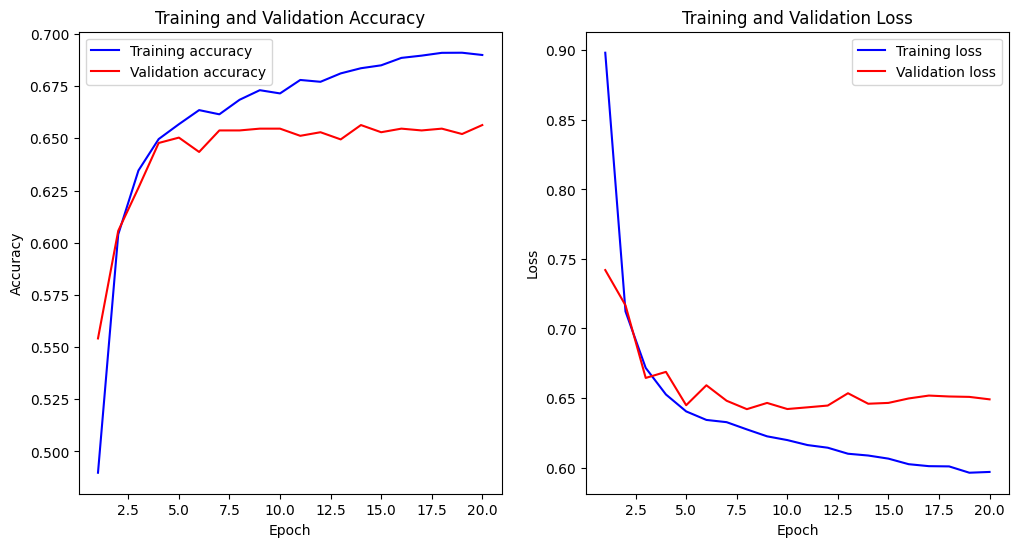

In [137]:
plot_training_history(itm.history)